# **Import Libraries**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBaseline
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import SVD
from surprise import SVDpp

# **Loading the data**

## **Reviews data**

In [2]:
df_video_games = pd.read_json('../amazon-data/Video_Games.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [3]:
df_cds = pd.read_json('../amazon-data/CDs_and_Vinyl.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [4]:
df_software = pd.read_json('../amazon-data/Software.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [5]:
df_music = pd.read_json('../amazon-data/Digital_Music.jsonl.gz', lines=True, compression='gzip', engine='pyarrow')

In [ ]:
#df_video_games.info()

## **Meta Data**

In [2]:
meta_video_games = pd.read_json('../amazon-data/meta_Video_Games.jsonl.gz', lines=True, compression='gzip')

In [3]:
meta_cds = pd.read_json('../amazon-data/meta_CDs_and_Vinyl.jsonl.gz', lines=True, compression='gzip')

In [4]:
meta_software = pd.read_json('../amazon-data/meta_Software.jsonl.gz', lines=True, compression='gzip')

In [5]:
meta_music = pd.read_json('../amazon-data/Digital_Music.jsonl.gz', lines=True, compression='gzip')

In [9]:
meta_video_games.sample(10)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
120405,Video Games,Championship Pool - Sega Genesis,4.3,4,[Championship Pool],[Includes game and original case. NO MANUAL Ga...,17.17,[{'thumb': 'https://m.media-amazon.com/images/...,[],Mindscape,"[Video Games, Legacy Systems, Sega Systems, Se...","{'Best Sellers Rank': {'Video Games': 165538, ...",B000035XNW,NaN,NaN,NaN
135525,None,"Wired N64 Controller,Upgrade Joystick Classic ...",2.8,2,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],ChooSe,"[Video Games, Legacy Systems, Nintendo Systems...",{'Pricing': 'The strikethrough price is the Li...,B08C286VF8,NaN,NaN,NaN
38826,Video Games,Microsoft Xbox LIVE 12 Month Gold Membership (...,4.7,6797,[Join the best community of gamers on the fast...,[Gaming is better with Xbox Live Gold. Join th...,None,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Xbox Live Gold', 'url': 'https://w...",Microsoft,"[Video Games, Online Game Services, Xbox Live,...","{'Release date': 'September 3, 2013', 'Best Se...",B00J9U2M12,NaN,NaN,NaN
95950,Video Games,247 Skins Graphics kit Sticker Decal Compatibl...,4.5,11,[Precision cut for a professional finish. Easy...,[This listing is for a vinyl decal for the Pla...,12.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],247Skins,"[Video Games, Legacy Systems, PlayStation Syst...","{'Best Sellers Rank': {'Video Games': 93367, '...",B00VXMLY4U,NaN,NaN,NaN
40258,Video Games,PlayStation VR - Astro Bot Rescue Mission + Mo...,3.7,31,[ASTRO BOT Rescue Mission is a brand new platf...,[This pre-owned or refurbished product has bee...,259.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Amazon Renewed,"[Video Games, PlayStation 4, PlayStation VR Ha...","{'Best Sellers Rank': {'Video Games': 87256, '...",B07Q5GNF22,NaN,NaN,NaN
66424,Cell Phones & Accessories,( For Samsung S8+ / Galaxy S8 Plus ) Durable P...,3.1,6,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Pinky Beauty Australia,"[Video Games, PC, Accessories, Headsets]",{'Package Dimensions': '7.24 x 3.15 x 0.39 inc...,B077LF6KLM,NaN,NaN,NaN
114628,Video Games,Microsoft Xbox 360 Skin (1st Gen) - NEW - CARB...,3.0,5,[Complete 11-Piece decal kit designed for maxi...,[Cover up your Microsoft Xbox 360 with a custo...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],System Skins,"[Video Games, Legacy Systems, Xbox Systems, Xb...","{'Best Sellers Rank': {'Video Games': 158582, ...",B001KNAI4E,NaN,NaN,NaN
78726,Video Games,Axiom Verge: Multiverse Edition (PS4),4.2,110,"[An expansive non-linear, alien world with ove...","[Product Description, In Axiom Verge , you pla...",None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Badland Games,"[Video Games, PlayStation 4, Games]","{'Release date': 'January 26, 2018', 'Pricing'...",B06XNQQXDD,NaN,NaN,NaN
108886,None,"PS5 Charging Station, PS5 Controller Charger S...",4.7,20,[【Fast Charging】The ps5 controller charger can...,[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],ECHTPower,"[Video Games, PlayStation 5, Accessories, Batt...","{'Best Sellers Rank': {'Video Games': 93331, '...",B093KQLHY2,NaN,NaN,NaN
56591,Video Games,Multi-function Cooling Stand with Fan and Dual...,3.8,7,"[Fashion design for PS4 Pro / Slim console, an...",[Multi-function Cooling Stand with Fan and Dua...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Luminira,"[Video Games, PlayStation 4]",{'Pricing': 'The strikethrough price is the Li...,B01MY07IMC,NaN,NaN,NaN


# **Data Processing**

In [11]:
df = pd.concat([df_video_games, df_cds, df_software, df_music], ignore_index=True)

In [12]:
df2 = df[["rating", "user_id", "parent_asin"]]

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14462503 entries, 0 to 14462502
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   rating       float64
 1   user_id      object 
 2   parent_asin  object 
dtypes: float64(1), object(2)
memory usage: 331.0+ MB


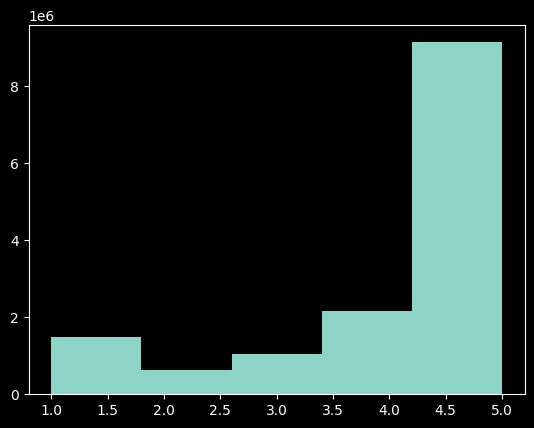

In [14]:
plt.hist(df2["rating"], bins=5) # how many ratings we have and how much
plt.show()

In [15]:
unique_users = len(df2["user_id"].unique())
unique_products = len(df2["parent_asin"].unique())
reviews_count = len(df2)
top = 5 # here we can change of what the most we want
print(f"Unique users: {unique_users}, Unique products: {unique_products}, Total reviews: {reviews_count}")

Unique users: 6533902, Unique products: 998679, Total reviews: 14462503


In [16]:
product_counts = df2["parent_asin"].value_counts()
popular_products = product_counts.reset_index()

In [17]:
num_products = (product_counts > top).sum()
print(f"Number of products with more than {top} reviews: {num_products}")

Number of products with more than 5 reviews: 235517


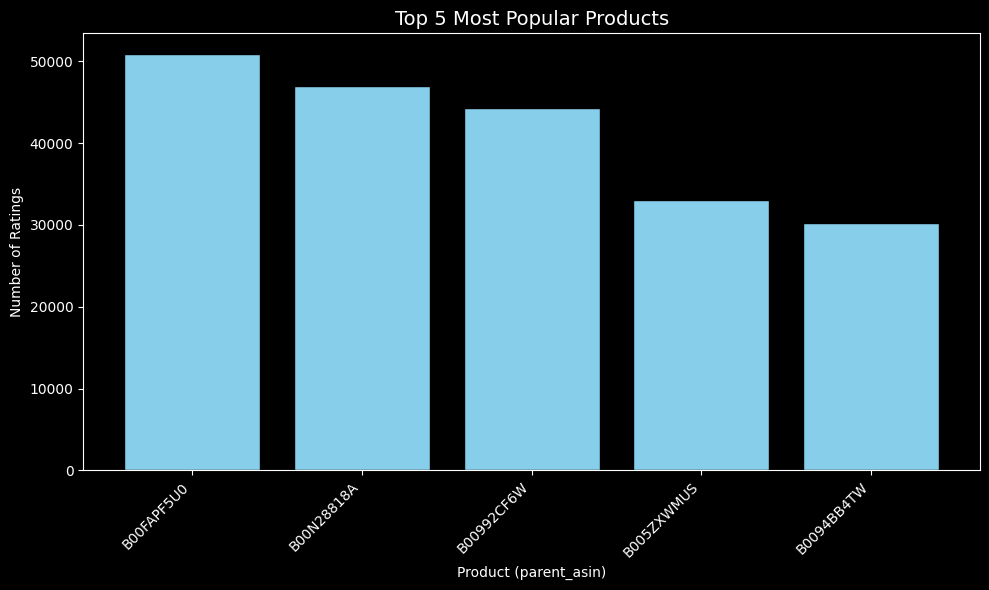

In [18]:
popular_products.columns = ["parent_asin", "rating"]
top15_product = popular_products.head(top)
plt.figure(figsize=(10, 6))
plt.bar(top15_product["parent_asin"], top15_product["rating"], color='skyblue', edgecolor='black')
plt.title(f"Top {top} Most Popular Products", fontsize=14)
plt.xlabel("Product (parent_asin)")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
users_counts = df2["user_id"].value_counts()
popular_users = users_counts.reset_index()
popular_users

,user_id,count
0,AHACUCDYWYSRABKYXOLDMTDP2NQQ_1,2665
1,AH3FC6V3IUJIN2Y7BCZ7DN3IMMJQ,2548
2,AGAFM74L2RIJ5O36NNYH4Z5ISQNQ,2512
3,AHEDJIDSPVYCB3GPRZKGO7YTK6XQ,2137
4,AF2QM5NTJ52WVY7GOGHVQJNU5IMA,1970
...,...,...
6533897,AFMV5TYYPRDHULK7YVVM776DQ6EQ,1
6533898,AHTLMB6FM3WPBG3WGIKP5F3SJAFQ,1
6533899,AGNOGQBWFK4ZLVR7ZBMFXQVIQXDA,1
6533900,AFCKSP564DBBPEXJQHJAUTPKCP6A,1


In [20]:
num_active_users = (users_counts > top).sum()
print(f"Number of users with more than {top} reviews: {num_active_users}")

Number of users with more than 5 reviews: 382272


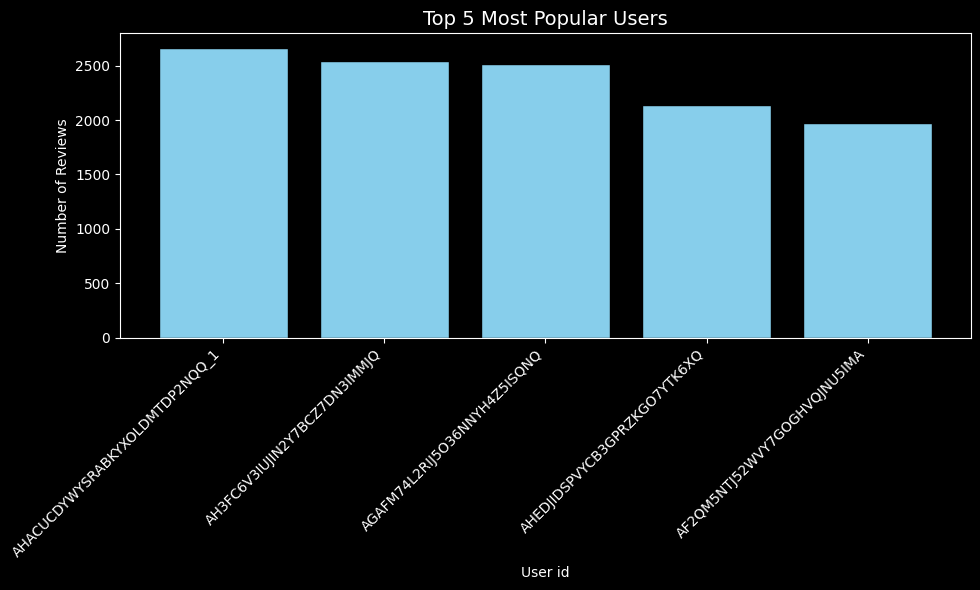

In [21]:
popular_users.columns = ["user_id", "rating"]
top15_user = popular_users.head(top)
plt.figure(figsize=(10, 6))
plt.bar(top15_user["user_id"], top15_user["rating"], color='skyblue', edgecolor='black')
plt.title(f"Top {top} Most Popular Users", fontsize=14)
plt.xlabel("User id")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Here i am checking thresholds for active items and users**

In [17]:
def calculate_sparsity(df_c, min_user_ratings, min_product_ratings):
    filtered_df = df_c.copy()
    user_counts = filtered_df["user_id"].value_counts()
    product_counts = filtered_df["parent_asin"].value_counts()

    filtered_df = filtered_df[filtered_df["user_id"].isin(user_counts[user_counts >= min_user_ratings].index)]
    filtered_df = filtered_df[filtered_df["parent_asin"].isin(product_counts[product_counts >= min_product_ratings].index)]

    n_users = filtered_df["user_id"].nunique()
    n_products = filtered_df["parent_asin"].nunique()
    n_ratings = len(filtered_df)
    sparsity = 1 - n_ratings / (n_users * n_products)

    return sparsity, n_users, n_products, n_ratings

for t in [15,20,25,30]:
    s, u, p, n = calculate_sparsity(df2, t, t)
    print(f"Threshold= {t:2d} Users={u:6d} Products={p:6d} Ratings={n:7d} Sparsity={s*100:6.2f}%")

Threshold= 15 Users= 73436 Products=101856 Ratings=1637055 Sparsity= 99.98%
Threshold= 20 Users= 43457 Products= 78168 Ratings=1166993 Sparsity= 99.97%
Threshold= 25 Users= 29160 Products= 62950 Ratings= 883096 Sparsity= 99.95%
Threshold= 30 Users= 21072 Products= 52692 Ratings= 695090 Sparsity= 99.94%


## **Here i am choosing the values of the active users and items**

In [22]:
min_user_ratings = 20
min_product_ratings = 20

user_counts = df2["user_id"].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
df_active = df2[df2["user_id"].isin(active_users)]

product_counts = df_active["parent_asin"].value_counts()
popular_products = product_counts[product_counts >= min_product_ratings].index
df_active = df_active[df_active["parent_asin"].isin(popular_products)]

n_users = df_active["user_id"].nunique()
n_products = df_active["parent_asin"].nunique()
n_ratings = len(df_active)
sparsity = 1 - n_ratings / (n_users * n_products)

print(f"Filtered dataset:")
print(f"Users: {n_users}")
print(f"Products: {n_products}")
print(f"Ratings: {n_ratings}")
print(f"Sparsity: {sparsity*100:.2f}%")

print("\nSample of the filtered dataset:")
print(df_active.head())

Filtered dataset:
Users: 41872
Products: 14143
Ratings: 715533
Sparsity: 99.88%

Sample of the filtered dataset:
    rating                       user_id parent_asin
28     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B0C3KYVDWT
30     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B07VGRJDFY
33     5.0  AFZUK3MTBIBEDQOPAK3OATUOUKLA  B00KTORA0K
70     5.0  AEVQ3KP55X4XECXWMHN6DHIDBYFQ  B002JTX9WQ
93     3.0  AFW2PDT3AMT4X3PYQG7FJZH5FXFA  B00O2GW3EO


## **Here i am loading data and put data into a diffrent models**

In [23]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_active[['user_id', 'parent_asin', 'rating']],reader)

### **KNNBaseline**

In [12]:
param_grid = {'k': [20, 30, 40,],'min_k': [3, 5, 7],'sim_options': {'name': ['cosine'],'user_based': [False],'shrinkage': [0, 50, 100]}}

In [13]:
gs = GridSearchCV(KNNBaseline,param_grid, measures=['rmse', 'mae'],cv=3,joblib_verbose=1)

In [14]:
gs.fit(data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 55.2min


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 89.4min finished


In [16]:
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

Best RMSE: 0.9732917288128998
Best params: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False, 'shrinkage': 0}}


In [17]:
best_knn = KNNBaseline(
    k=gs.best_params['rmse']['k'],
    min_k=gs.best_params['rmse']['min_k'],
    sim_options=gs.best_params['rmse']['sim_options']
)

In [25]:
trainset, testset = train_test_split(data, test_size=0.2)

In [26]:
best_knn.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [27]:
results_knn =cross_validate(best_knn,data,measures=['RMSE', 'MAE'],cv=3,verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9742  0.9710  0.9727  0.9726  0.0013  
MAE (testset)     0.6908  0.6897  0.6916  0.6907  0.0008  
Fit time          76.02   85.72   68.11   76.62   7.20    
Test time         12.12   9.72    9.89    10.58   1.09    


### **SVD**

In [21]:
algo_svd =SVD()

In [22]:
results_svd =cross_validate(algo_svd,data,measures=['RMSE', 'MAE'],cv=3,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9765  0.9765  0.9754  0.9761  0.0005  
MAE (testset)     0.7034  0.7034  0.7020  0.7029  0.0007  
Fit time          4.36    5.27    7.28    5.64    1.22    
Test time         1.71    3.43    2.99    2.71    0.73    


In [26]:
print("Mean MAE:",results_svd['test_mae'].mean())

Mean MAE: 0.7033039815254286


In [27]:
param_grid = {'n_factors':[50,60],'n_epochs':[40, 50],'lr_all':[0.005],
              'reg_all': [0.07, 0.09]}

gs = GridSearchCV(SVD,param_grid, measures=['rmse'],cv=3,joblib_verbose=2)
gs.fit(data)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  3.8min finished


In [26]:
print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

Best RMSE: 0.9637184139354771
Best params: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.07}


### **SVD++**

In [28]:
algo_svdpp = SVDpp()

In [29]:
results = cross_validate(algo_svdpp, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9701  0.9686  0.9692  0.9693  0.0006  
MAE (testset)     0.6821  0.6819  0.6815  0.6818  0.0003  
Fit time          14.97   13.50   15.54   14.67   0.86    
Test time         8.77    8.09    10.05   8.97    0.81    


In [ ]:
param_grid = {'n_factors':[60, 70],'n_epochs':[30, 40],'lr_all':[0.005, 0.007],
              'reg_all': [0.09, 0.11]}

In [32]:
gs_svdpp = GridSearchCV(SVDpp,param_grid, measures=['rmse'],cv=3,joblib_verbose=2)
gs_svdpp.fit(data)

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 24.5min finished


In [33]:
print("Best RMSE:", gs_svdpp.best_score['rmse'])
print("Best params:", gs_svdpp.best_params['rmse'])

Best RMSE: 0.9606147285665482
Best params: {'n_factors': 60, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.09}


## **Here i am loading the models with the best params**

In [28]:
best_svd = SVD(n_factors=50,n_epochs=40,lr_all=0.005,reg_all=0.07)

In [29]:
knn = KNNBaseline(k=40, min_k=5, sim_options={'name': 'cosine', 'user_based': False, 'shrinkage': 0})

In [30]:
svdpp = SVDpp(n_factors=60, n_epochs=40, lr_all=0.005, reg_all=0.09)

## **This is a functions for using a hybrid methods based on weight**

In [31]:
def hybrid_predict_weighted(u_id, i_id,svd, knn, w):
    svd_pred =svd.predict(u_id, i_id).est
    knn_pred =knn.predict(u_id,i_id).est
    return w* svd_pred + (1 -w)* knn_pred

In [32]:
def evaluate_weight(w,svd, knn,testset):
    errors =[]
    for u_id, i_id, true_r in testset:
        est =hybrid_predict_weighted(u_id, i_id,svd,knn, w)
        errors.append((true_r -est) **2)
    return np.sqrt(np.mean(errors))

In [33]:
def hybrid3_predict(uid, iid, svd, svdpp, knn, w1, w2, w3):
    svd_pred   = svd.predict(uid, iid).est
    svdpp_pred = svdpp.predict(uid, iid).est
    knn_pred   = knn.predict(uid, iid).est

    return (w1*svd_pred + w2*svdpp_pred + w3*knn_pred)

## **Train and Test**

In [34]:
trainset, testset = train_test_split(data, test_size=0.2)
best_svd.fit(trainset)
knn.fit(trainset)
svdpp.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [35]:
weights = [
    (0.33,0.33,0.34), (0.2,0.4,0.4), (0.4,0.3,0.3), (0.5,0.3,0.2),
    (0.6,0.3,0.1), (0.3,0.5,0.2), (0.25,0.45,0.3), (0.1,0.7,0.2)]
def evaluate(w1,w2,w3):
    errors = []
    for uid, iid, true_r in testset:
        est = hybrid3_predict(uid,iid,best_svd,svdpp,knn,w1,w2,w3)
        errors.append((true_r-est)**2)
    return np.sqrt(np.mean(errors))

results = {}
for w1,w2,w3 in weights:
    rmse = evaluate(w1,w2,w3)
    results[(w1,w2,w3)] = rmse
    print(f"Weights={w1,w2,w3} RMSE={rmse:.5f}")

best = min(results, key=results.get)
print("\nBest config:", best, " RMSE:", results[best])

Weights=(0.33, 0.33, 0.34) RMSE=0.94871
Weights=(0.2, 0.4, 0.4) RMSE=0.94889
Weights=(0.4, 0.3, 0.3) RMSE=0.94883
Weights=(0.5, 0.3, 0.2) RMSE=0.94934
Weights=(0.6, 0.3, 0.1) RMSE=0.95057
Weights=(0.3, 0.5, 0.2) RMSE=0.94860
Weights=(0.25, 0.45, 0.3) RMSE=0.94843
Weights=(0.1, 0.7, 0.2) RMSE=0.94928

Best config: (0.25, 0.45, 0.3)  RMSE: 0.948434956339673


In [36]:
weights = [0.6,0.61,0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7]

In [37]:
results = {}
for w in weights:
    rmse = evaluate_weight(w,best_svd, knn, testset)
    results[w] = rmse
    print(f"w={w:.2f} RMSE={rmse:.5f}")
best_w = min(results, key=results.get)
print("\nBest weight:", best_w, "with RMSE:", results[best_w])

w=0.60 RMSE=0.95162
w=0.61 RMSE=0.95163
w=0.62 RMSE=0.95164
w=0.63 RMSE=0.95166
w=0.64 RMSE=0.95169
w=0.65 RMSE=0.95172
w=0.66 RMSE=0.95176
w=0.67 RMSE=0.95181
w=0.68 RMSE=0.95186
w=0.69 RMSE=0.95193
w=0.70 RMSE=0.95200

Best weight: 0.6 with RMSE: 0.9516223970072785


In [38]:
summary = pd.DataFrame([
    {"Model": "KNNBaseline (Tuned)","RMSE": 0.9732},
    {"Model": "SVD (Tuned)","RMSE": 0.9637},
    {"Model": "SVD++", "RMSE": 0.9606},
    {"Model": "Hybrid (SVD + KNN)","RMSE": 0.9504},
    {"Model": "Hybrid (SVD + SVD++ + KNN best)","RMSE": 0.94794},
])

summary

,Model,RMSE
0,KNNBaseline (Tuned),0.97320
1,SVD (Tuned),0.96370
2,SVD++,0.96060
3,Hybrid (SVD + KNN),0.95040
4,Hybrid (SVD + SVD++ + KNN best),0.94794


# **Data Processing of Meta Data**

In [6]:
meta = pd.concat([meta_video_games, meta_cds, meta_software, meta_music], ignore_index=True)

In [7]:
meta = meta[['parent_asin','title','main_category',
             'average_rating','rating_number','categories']]

In [41]:
meta = meta.drop_duplicates(subset='parent_asin')

In [42]:
df_full = df_active.merge(meta, on='parent_asin', how='left')

# Saving the clean data

In [54]:
df[["user_id", "parent_asin", "rating"]].to_parquet("models/user_interactions_all.parquet",index=False)

In [12]:
meta[["parent_asin", "title", "main_category"]].drop_duplicates().to_parquet("items_meta.parquet",index=False)

In [57]:
user_stats = (df.groupby("user_id").agg(interaction_count=("rating", "count"),mean_rating=("rating", "mean")).reset_index())
user_stats["cf_eligible"] = user_stats["interaction_count"] >= 20
user_stats.to_parquet("models/user_stats.parquet",index=False)

0          False
1          False
2          False
3          False
4          False
           ...  
6533897    False
6533898    False
6533899    False
6533900    False
6533901    False
Name: cf_eligible, Length: 6533902, dtype: bool


In [59]:
print(user_stats['cf_eligible'].value_counts())

cf_eligible
False    6490185
True       43717
Name: count, dtype: int64


In [60]:
joblib.dump(knn, "../models/knn.pkl")
joblib.dump(best_svd, "../models/svd.pkl")
joblib.dump(svdpp, "../models/svdpp.pkl")

['artifacts/hybrid_weights.pkl']